# Using feature importance to identify which metrics are the cause of performance problems

In this notebook I'll demonstrate how to use feature importance to identify which of the many metrics available are the highest factors in intermittant system or transaction performance problems.

I've used this technique to identify performance problems from a large dataset of monitoring values which were otherwise not immediately apparent. We had captured over 30 timing and other metrics (thread counts, locations, etc) for many thousands of transactions but the issue was never clear enough in that data to identify which component was causing the performance issue. Using the below technique however I was able to pinpoint the component that factors the most in to a transaction which exceeded SLA values.

In this notebook I'll:
1. Generate a set of timings over 2 components
2. Add a random error to one of those components
3. Use [feature importance](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) to correctly identify which of the compents introduced the errors.

This first section will generate and add the errors to the data

In [48]:
# Import pandas to work with the data, random to generate our values
import pandas as pd
from random import random

# We'll generate 10000 random transactions to work with
# and store them in a pandas DataFrame.
transaction_ids = range(10000)

df = pd.DataFrame()
df['transaction_id'] = transaction_ids


# Component 1 timings
# We'll generate some random data to show each step this compoment performs 
# But there will be no correlation here between a transaction of concern and
# of no concern.
df['component_1_step_1'] = [random() for x in transaction_ids]
df['component_1_step_2'] = [random() for x in transaction_ids]
df['component_1_step_3'] = [random() for x in transaction_ids]


# Component 2 timings 
# This will be the source of our slow perfromance that we will identify later.
# Step 1 for this component will show no concern.
df['component_2_step_1'] = [random() for x in transaction_ids]


# Here we have a function to generate a 10% error rate in to the data, we'll
# use this to make some random values for the step 2 and 3 that component 2 
# performs.
def make_random_errors(x):
    # 10% error rate
    if x % 10 == 0:
        error_amount = 2.0 + random() * 3
    else:
        error_amount = 0.0
    
    return random() + error_amount

df['component_2_step_2'] = [make_random_errors(x) for x in transaction_ids]
df['component_2_step_3'] = [make_random_errors(x) for x in transaction_ids]


# Now we have our component timings, sum them all up to create a total transaction
# time. 
df['total_transaction_time'] = df.component_1_step_1 + \
                               df.component_1_step_2 + \
                               df.component_1_step_3 + \
                               df.component_2_step_1 + \
                               df.component_2_step_2 + \
                               df.component_2_step_3        

At this point we should have a set of data in df which may look like any set of metrics you can extract from an application.

Now we need to frame the question that we want to answer.

For this set of data we know we have a transaction SLA of 5 seconds, however the problem has been some transactions are taking longer than that. After investigations it's not immediately apparent what is the cause of these issues. So we want to ask:

"Which of the recorded timing values contibutes the most to the total transaction time being longer than 5 seconds?"

To complete this we will add a column to the dataset that flags if a transaction is over 5 seconds or not.

In [49]:
# Create our concern value. A transaction is of concern if the 
# total transaction time is greater than 5.0 seconds (our SLA in this example)
df['concern'] = [1.0 if x > 5.0 else 0.0 for x in df.total_transaction_time]

# Count how many transactions are of concern in our data:
df[['transaction_id','concern']].groupby('concern').count()

,transaction_id
concern,
0.0,8991
1.0,1009


The above shows we've created roughly 10% of our transactions over 5 seconds.

The next step is to prepare our data for the classifier, we're going to turn it in to two separate arrays for [Features](https://en.wikipedia.org/wiki/Feature_(machine_learning)) and [Labels](https://en.wikipedia.org/wiki/Supervised_learning). These are machine learning terms and they normally are stored in X and y. It's outside the scope of how/why this is, but we're going to leverage this to determine which of the metrics influences the transaction times the most so we can narrow down our focus on where to examine next.

In forming X, we do not want to include the total transaction time as it will have a 1:1 relationship with the transaction being over 5 seconds or not. We include all our other timing columns that we created (or other metrics from different sources of data).

y will be the concern value, what we want to map all these timing values too.

In [54]:
X = df[['component_1_step_1','component_1_step_2','component_1_step_3',
       'component_2_step_1','component_2_step_2','component_2_step_3']]

y = df[['concern']].values.ravel() # to create the 1d array that the classifier expects

This section is where the processing occurs. We're using scikit learn and their [example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) of feature importance to take our metrics data and tell us which of the columns are the biggest contributors to the transaction taking longer than 5 seconds or not.

In [51]:
# Using this example as a template:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

# Fit the model to our metrics data
forest.fit(X, y)

# Extract the feature importance from the model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
# This array now contains the columns in order of how important they are to
# the make up of the label.
indices = np.argsort(importances)[::-1]

Now we have three arrays:
1. indicies: The column rankings in order of how important they are to the concern value
2. importance: The percentage value of how important they are to the concern value
3. X.columns: Contains the column names that we can then use to create our output.

We can then print out the columns in order of the rank given by the classifer:

In [52]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{rank}. {index} {column} ({importance:0.3f})".format(rank=f + 1, 
                                                   index=indices[f],
                                                   column=X.columns[indices[f]], 
                                                   importance=importances[indices[f]]))


Feature ranking:
1. 5 component_2_step_3 (0.542)
2. 4 component_2_step_2 (0.450)
3. 0 component_1_step_1 (0.002)
4. 2 component_1_step_3 (0.002)
5. 1 component_1_step_2 (0.002)
6. 3 component_2_step_1 (0.002)


This output shows that values in columns 4 + 5 contribute a total of 96% over the value of concern being a 1 or 0.

And for our question:
"Which of the recorded timing values contibutes the most to the total transaction time being longer than 5 seconds?"

We now have an answer: We need to focus our investigations on why component 2 is intermittantly slow, specifically what is being performed on step 2 and step 3.

We can also see this in graph form:

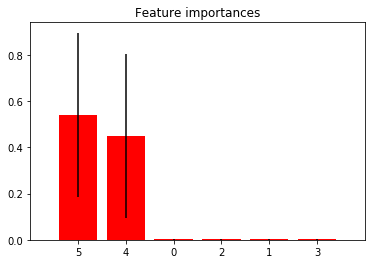

In [53]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In the real-world example there were many other metrics being collected, and due to a historical issue on one of those metrics all investigations were focused on that point (for example, on component 1). What we're able to do with this is is redirect the investigation to the actual causes of the problems, saving time by not having to reinvestiate Component 1  to identify an issue that never existed there.